In [1]:
import sys
import os

import torch
from PIL import Image
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange

sys.path.append("../")
from CLIP.clip import load, tokenize
from CLIP.clip.simple_tokenizer import SimpleTokenizer

In [2]:
device = torch.device("cuda")

In [3]:
model, transform = load("ViT-B/32", jit=False, device=device)
model = model.eval().float()

In [4]:
tokenizer = SimpleTokenizer()

In [5]:
def decode_text(model, embedding):
    # from embed weights to tokens
    embed_weights = model.token_embedding.weight.data
    decoded_tokens = np.array([torch.argmin(torch.norm(embed_weights - e, dim=-1)).item() for e in embedding.squeeze(0)])
    decoded_tokens = decoded_tokens[decoded_tokens != 0][1:-1] # ignore empty stops, start, and end token
    decoded_text = tokenizer.decode(decoded_tokens)
    return decoded_text

['Autumn_1875_Frederic_Edwin_Church.jpg', 'ouzi.jpg', '.ipynb_checkpoints', 'anton_climb.jpg', 'hot-dog.jpg']


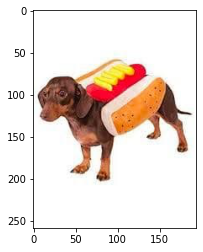

In [852]:
# load image
base_images = os.listdir("base_images")
print(base_images)
img_name = base_images[-1]
img = Image.open("base_images/" + img_name).convert("RGB")
norm = transform.transforms[-1]
plt.imshow(img)

In [864]:
# create start text
start_token = 1
text = "A picture of a man"
tokens = tokenize(text)
print(tokens)

embed = model.embed_text(tokens.to(device)).detach()
embed_std = embed.std()
embed_mean = embed.mean()

max_idx = tokens.argmax()
opt = embed[0, start_token: max_idx].clone().detach().requires_grad_(True)
opt_norm = opt.detach().norm(dim=-1).mean().item()
opt_mean = opt.detach().mean(dim=-1).mean().item()
opt_std = opt.detach().std(dim=-1).mean().item()

embed[0, start_token: max_idx] = 0
print(opt.shape)
print(opt_norm)
print(opt.mean())
print(opt.std())

tensor([[49406,   320,  1674,   539,   320,   786, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])
torch.Size([5, 512])
0.24962925910949707
tensor(-5.7280e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0111, device='cuda:0', grad_fn=<StdBackward0>)


In [865]:
t = T.Compose([#T.Resize((224, 224)),
               T.RandomResizedCrop(224, scale=(0.6, 1.0), ratio=(0.9, 1.1)),
               
    
               #T.RandomAffine([0, 10], 
               #     translate=(0, 0.3),
               #     scale=(0.8, 1.0), 
               #     shear=(0.5, 0.8),
               #     fillcolor=255),
              #T.RandomGrayscale(p=0.2),
              #T.RandomPerspective(distortion_scale=0.3,
              #                    p=0.3,
              #                    fill=255),
               T.ToTensor(),
               norm,
            ])
# demonstrate transform
#T.ToPILImage()(t(img))

In [866]:
lr = 0.04
steps = 100
bs = 16

optimizer = torch.optim.Adam([opt], lr=lr)#, weight_decay=0.2)

norm_img = norm(T.ToTensor()(img.resize((224, 224)))).unsqueeze(0).to(device)
with torch.no_grad():
    norm_img_feats = model.encode_image(norm_img)

best_text = None
best_text_loss = 100
    
aug_losses = []
losses = []
text_losses = []

pbar = trange(steps)
for step in range(steps):
    embedding = embed.clone()
    embedding[0, start_token:max_idx] += opt
    
    embedding_batch = embedding
    #embedding_batch = torch.cat([embedding + torch.zeros_like(embedding).normal_(mean=0, std=embed_std.item() / 10) for _ in range(bs)])
    text_feats = model.encode_text(tokens, embedding=embedding_batch).to(device)
    
    img_batch = img
    img_batch = torch.stack([t(img) for _ in range(bs)])
    with torch.no_grad():
        img_feats = model.encode_image(img_batch.to(device))
        
    norm_loss = (opt.norm(dim=-1).mean() - opt_norm) ** 2
    mean_loss = (opt.mean(dim=-1).mean() - opt_mean) ** 2
    std_loss = (opt.std(dim=-1).mean() - opt_std) ** 2
    reg_loss = norm_loss + mean_loss + std_loss
    
    loss = -1 * (torch.nn.functional.cosine_similarity(text_feats, img_feats)).mean() + reg_loss * 0.05
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # move opt back to orig stats - does not work
    #with torch.no_grad():
    #    opt = (opt - opt.mean(dim=-1, keepdim=True)) / opt.std(dim=-1, keepdim=True)
    #    opt = (opt * opt_std) + opt_mean
    
    # calc non-augmented loss
    non_aug_loss = -1 * (torch.nn.functional.cosine_similarity(text_feats, norm_img_feats))
    # log losses
    aug_losses.append(loss.item())
    losses.append(non_aug_loss.item())
    # decode text
    current_text = decode_text(model, embedding)
    # calc loss based on decoded text
    decode_loss = -1 * (torch.nn.functional.cosine_similarity(model.encode_text(tokenize(current_text).to(device)), norm_img_feats)).item()
    text_losses.append(decode_loss)
    
    if decode_loss < best_text_loss:
        best_text = current_text
        best_text_loss = decode_loss
    
    pbar.update(1)
    pbar.set_description(current_text + " - aug loss " + str(round(loss.item(), 2)) + " loss " + str(round(non_aug_loss.item(), 2)) + " decode loss " + str(round(decode_loss, 2)))

In [867]:
(opt_norm - opt.norm(dim=-1).mean()).item()

-1.1829601526260376

In [868]:
#'ó charismatic herr sunsetgrayson' - for me
#'" landscapes voyage schelthur' - for autumn
#'patient �📝: rito grows ' - for ouzi
#'roomie stru<|startoftext|>saharan collie ' for ouzi
#'photoshopped yikes .- hotdog watches ' - for hot-dog

In [869]:
best_text

'adog masculine rog<|startoftext|>indiegamedev '

In [870]:
torch.nn.functional.cosine_similarity(model.encode_text(tokenize(best_text).to(device)), norm_img_feats).item()

0.2561683654785156

In [871]:
torch.nn.functional.cosine_similarity(model.encode_text(tokenize("A picture of a boy").to(device)), norm_img_feats).item()

0.21457655727863312

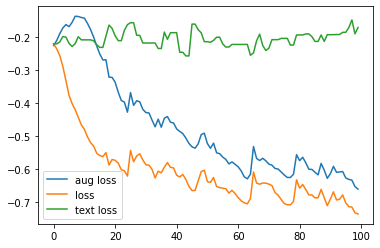

In [872]:
plt.plot(aug_losses, label="aug loss")
plt.plot(losses, label="loss")
plt.plot(text_losses, label="text loss")
plt.legend()

In [873]:
decode_text(model, embedding)

'seaworld safest hosp 0�️ '

In [13]:
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

KeyboardInterrupt: 

In [ ]:
input_ids = tokenizer("Let me tell you something about this girl named Emilia Wiehe.", return_tensors="pt").input_ids

In [ ]:
gen_tokens = model.generate(input_ids, do_sample=True, temperature=0.9, max_length=100,)

In [ ]:
gen_text = tokenizer.batch_decode(gen_tokens)[0]

In [ ]:
gen_text

In [ ]:
gen_text

In [ ]:
gen_tokens = model.generate(past_key_values=torch.zeros(5, 2048), do_sample=True, temperature=0.9, max_length=100, use_cache=True)

In [ ]:
gen_text = tokenizer.batch_decode(gen_tokens)[0]

In [ ]:
gen_text

In [ ]:
gen_tokens

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [ ]:
generated = tokenizer.encode("My feet")
context = torch.tensor([generated])
past = None

for i in tqdm(range(100)):
    output = model(context, past_key_values=past, use_cache=True)
    logits = output["logits"]
    past = output["past_key_values"]
    token = torch.argmax(logits[..., -1, :])

    generated += [token.tolist()]
    context = token.unsqueeze(0)

sequence = tokenizer.decode(generated)

print(sequence)

In [ ]:
for vec in past:
    for ten in vec:
        ten.requires_grad_(True)

In [ ]:
gen_tokens = model.generate(past_key_values=past, do_sample=True, temperature=0.9, max_length=100, use_cache=True)

In [ ]:
gen_text = tokenizer.batch_decode(gen_tokens)[0]
gen_text

In [ ]:
len(out)

In [ ]:
out[0].shape

In [ ]:
len(out[1])

In [ ]:
len(out[1][0])

In [ ]:
out[1][0][0].shape

In [ ]:
for step in range(opt_steps):
    text_feats = model.encode_text(opt_tokens.cuda())
    
    loss = -1 * torch.nn.functional.cosine_similarity(text_feats, img_feats)
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    print(opt_tokens)
